# Tutorial
This tutorial is a work in progress. 


In [7]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [8]:
#
# required packages to run the script
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticke
import seaborn as sns
from matplotlib.colors import LogNorm
import math
import os
import pickle as pkl
from scipy import sparse
from scipy.sparse.linalg import lsqr
import scipy.fftpack
import xlsxwriter
import importlib


In [9]:
# 
# Importing functions 
from import_excel import import_excel
from calc_translations import load_trans
from calc_translations import translate
from wavelet_decomposition import compute_betas
from wavelet_decomposition import stack_betas
from wavelet_decomposition import preplotprocessing
from wavelet_decomposition import reconstruct
from wavelet_decomposition import sine_function
from plots import plot_betas_heatmap
from plots import plot_EPN
from calc_EPN import calc_epn
from plots import fft

# All control parameters goes here

In [10]:
#
# Path
path_input_data = "..\\RTE_time_series\\"
input_file = 'input_time_series.xlsx'
#
beta_path = "betas\\square_shape\\"

#
path_trans = 'translation//'


In [11]:
#
# Options of the wavelet decomposition
vy = 6  # vectors per yearsave
vw = 3  # vectors per week
vd = 6  # vectors per day

vecNb_yr = vy
vecNb_week = vw
vecNb_day = vd

time_scales = [0.75, 1.5, 3., 6., 12, 24., 42., 84., 168., 273.75, 547.5, 1095., 2190., 4380.,
              8760.] # cycles length, in hours

# 
# Controle parameters"
time_series = ['Consommation', 'Eolien', 'Solaire']
# for the signal interpolation
dpd = 48 # data per year
ndpd = 64 # new data per year (for the interpolation)
dpy = 365 # data per year :  cut the leap years to 365 years (annee bissexitle)
signal_length = ndpd * dpy

#
load_factor = 54e+3 # 54 GW
#Mean value of electricity load

# Importing excel time series

There is 7 years imported
['2012', '2013', '2014', '2015', '2016', '2017', '2018']


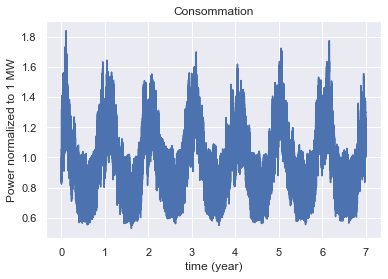

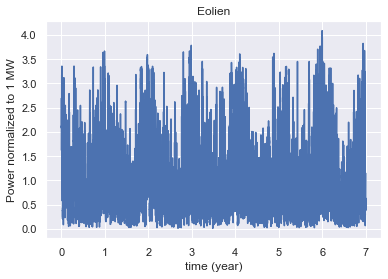

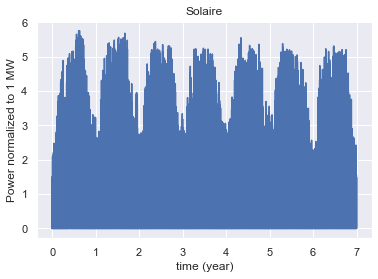

In [27]:
# Once daata are imported, comment lines bellow and uncomment the last one
stacked_input_data, years = import_excel(path_input_data,input_file, 
                                    dpd ,ndpd, dpy, time_series, 
                                    interp=True)
pkl.dump([stacked_input_data, years], open('temp_save' + '.p', "wb") )

# Uncomment once date are imported
# [stacked_input_data, years]= pkl.load(open('temp_save' + '.p', "rb"))

# Starting the wavelet decomposition

Signal is decomposed over a set of wavelets of 15 time scales :  [0.75, 1.5, 3., 6., 12, 24., 42., 84., 168., 273.75, 547.5, 1095., 2190., 4380.,
              8760.] hours
              
The time scale could be understood as the duration of charge-discharge of a storage device

__This set of wavelets is built such that:__
- There is 3 mother wavelets with different durations : _Year_, _Week_ and _Day_
- Those 3 wavelets have a physical meaning and account for human and season cycles. Therefore, we want to make sure that the year time scale is properly center over the year (summer un summer and winter in winter), that dayly wavelets are starting from 12pm to 12 pm and not 5am to 5am,...
- For this  reason we should compute and use translations, as shown in the cell below
- The mother wavelets are then divided in daugther wavelets

In [15]:
'''
First, optimal translations for the year, week and day mother wavelets
- if do_calc is false, translations are imported.
'''
trans_file = 'new_trans_square_12_18'

trans_square = load_trans(path_trans, trans_file,
                   stacked_input_data, 'Consommation',
                   ndpd, dpy, 
                   'square', do_calc = False)

Importing translations


In [16]:
'''
Second, we compute the coefficients of the wavelet decomposition
- wl_shape : either 'sine_function' or 'square' shape
- To compute new matrix use imp_matrix = False. It can take one hour !
'''
path_matrix = "saved_matrix\\square_shape\\"
stacked_betas_square, saved_sheets_square = compute_betas(time_series, stacked_input_data,
                 vecNb_yr, vecNb_week, vecNb_day, dpy, ndpd, years,
                 trans_square,
                 path_matrix,
                 beta_path, wl_shape ='square', imp_matrix = True)

pkl.dump([stacked_betas_square, saved_sheets_square], open('betas_saved_square' + '.p', "wb"))

# [stacked_betas_square, saved_sheets_square] = pkl.load(open('betas_saved_square' + '.p', "rb"))

saved_matrix\square_shape\A_2012.npz
Importing matrix A square
Square sparsee matrix or year 2012 has been imported
saved_matrix\square_shape\A_2013.npz
Importing matrix A square
Square sparsee matrix or year 2013 has been imported
saved_matrix\square_shape\A_2014.npz
Importing matrix A square
Square sparsee matrix or year 2014 has been imported
saved_matrix\square_shape\A_2015.npz
Importing matrix A square
Square sparsee matrix or year 2015 has been imported
saved_matrix\square_shape\A_2016.npz
Importing matrix A square
Square sparsee matrix or year 2016 has been imported
saved_matrix\square_shape\A_2017.npz
Importing matrix A square
Square sparsee matrix or year 2017 has been imported
saved_matrix\square_shape\A_2018.npz
Importing matrix A square
Square sparsee matrix or year 2018 has been imported
saved_matrix\square_shape\A_2012.npz
Importing matrix A square
Square sparsee matrix or year 2012 has been imported
saved_matrix\square_shape\A_2013.npz
Importing matrix A square
Square sp

In [17]:
#
# The wavelet decomposition is saved in a disctionnary with the following sstructure:
print(saved_sheets_square.keys())
print(saved_sheets_square['Consommation'].keys())
print(saved_sheets_square['Consommation']["2012"][14]) # 14th time scale

dict_keys(['Consommation', 'Eolien', 'Solaire'])
dict_keys(['2012', '2013', '2014', '2015', '2016', '2017', '2018'])
[0.05715584044632578]


# Plots
The waveley decomposition can be depicted with a heatmaps.
Ewample on the cells below


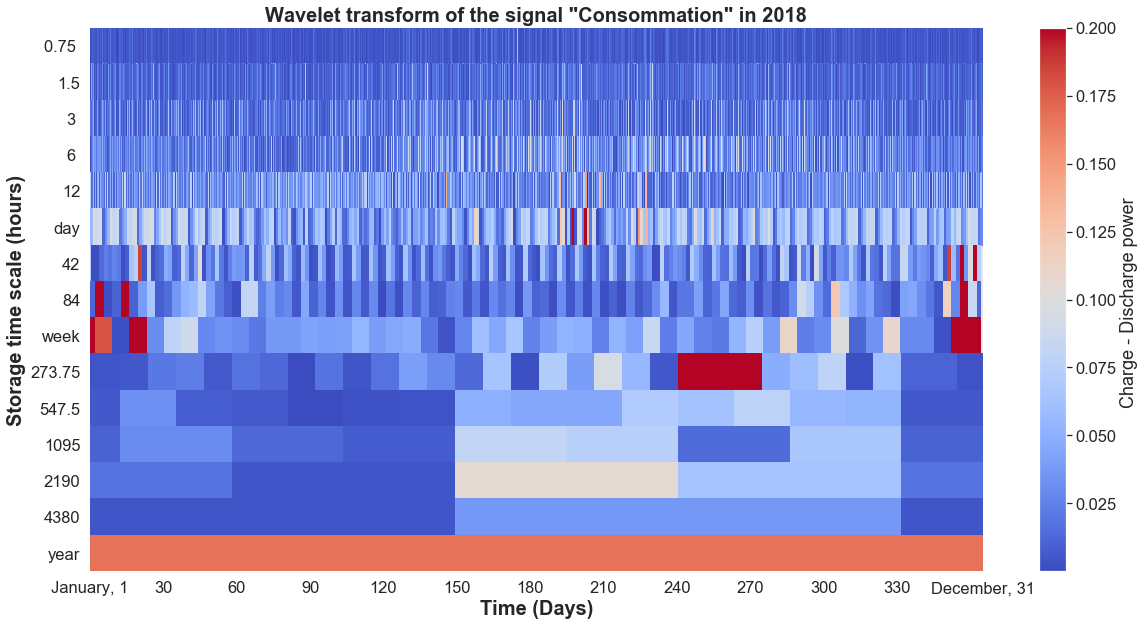

In [21]:
# Forst, select the year
year = '2018'
# 
df= preplotprocessing(vecNb_yr, vecNb_week , vecNb_day, ndpd, dpy, 'Consommation', #Then the kind of signal. In this tutorial its either 'Consommation', 'Eolien' or 'Solaire
                      year, years,
                      saved_sheets_square, # Here is the datasheet you want to plot. This datasheet is returned by the function compute_betas(). Here is ploted the square decomposition
                      do_trans = trans_square) # Eventualy retranslate the decomposition to make it feet to the week, day and sesonal cycles

plot_betas_heatmap(df, 'Consommation', year , ndpd,
                      cmin= None,
                      cmax= 0.2,
                    ccenter = None)

In [ ]:
## Other heatmaps
# df_eol   = preplotprocessing(vecNb_yr, vecNb_week , vecNb_day, ndpd, dpy, 'Eolien', year, years, saved_sheets_square,   do_trans = trans_square)
# df_pv    = preplotprocessing(vecNb_yr, vecNb_week , vecNb_day, ndpd, dpy, 'Solaire', year, years, saved_sheets_square,  do_trans = trans_square)

# plot_betas_heatmap(df_eol, 'Eolien', year ,ndpd,
#                       cmin= None,
#                       cmax = 3,
#                       ccenter= None)
# plot_betas_heatmap(df_pv, 'Solaire', year ,ndpd,
#                       cmin= None,
#                       cmax=2,
#                       ccenter= None)


## Comparison of a wavelet decomposition and Fourier transform

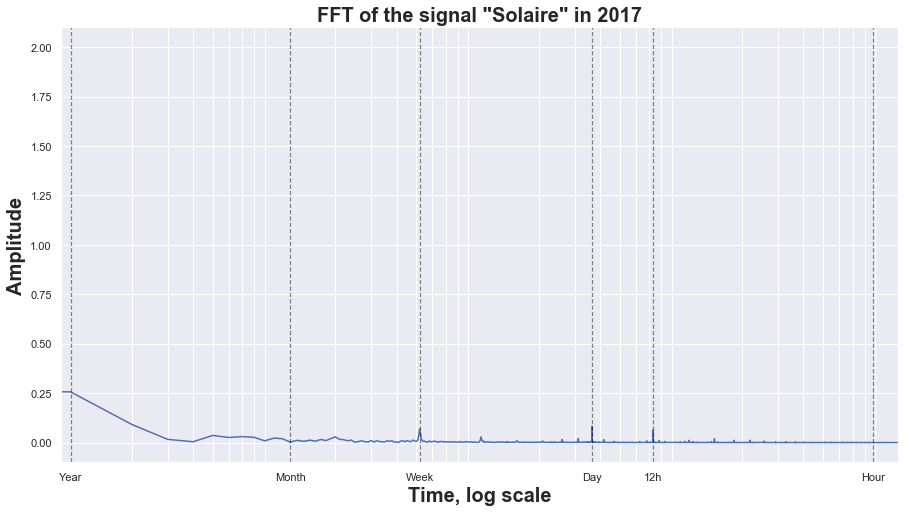

In [28]:
# importlib.reload(plots.fft)
year='2017'
index = years.index(year)
input_data = stacked_input_data['Consommation'][signal_length*index:signal_length*(index+1)]
fft(ndpd, dpy, signal, year, input_data)

# Computing Energy, Power, and Nb of Cycles
### From the coefficients betas of the wavelet decomposition, we can determine the flexibility required by the energy system

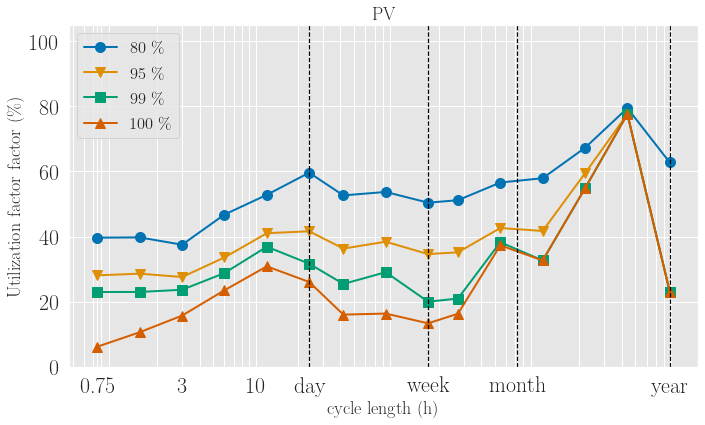

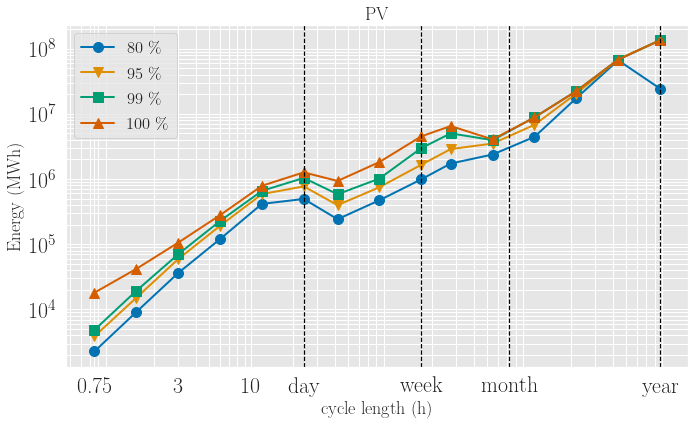

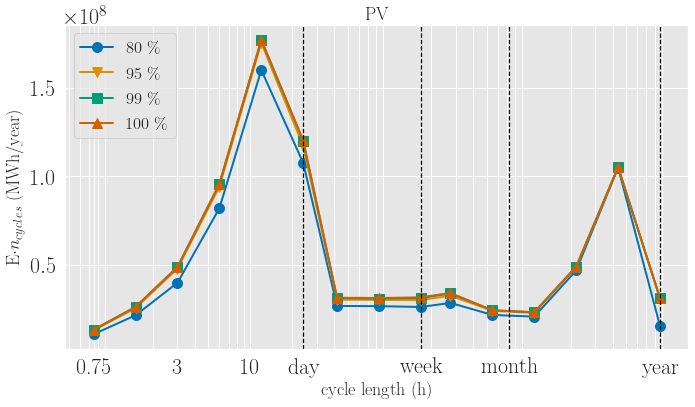

In [29]:
# An example for an extreme case : 100% of electricity is produced by PV
scenario_name = 'PV'
conso = stacked_betas_square['Consommation']
prod =  stacked_betas_square['Solaire']

pmc = [np.array(prod[i]) - np.array(conso[i]) for i in range(len(time_scales)) ]

satisfactions = [80,95,99,100] # Satisfaction rate
# Percentage of the time the load will be met by the storage device.

satisfaction_labels = [str(satis)+'%' for satis in satisfactions]
# -------------------------------
# ------- Compute and plot E,P and N
#
results = calc_epn(pmc, satisfactions, time_scales, dpy, load_factor)
plot_EPN(results['emax'], results['pmax'], results['n'], results['uf'], results['serv'],
         time_scales, satisfactions, scenario_name )

# Reconstructing and filtering signals

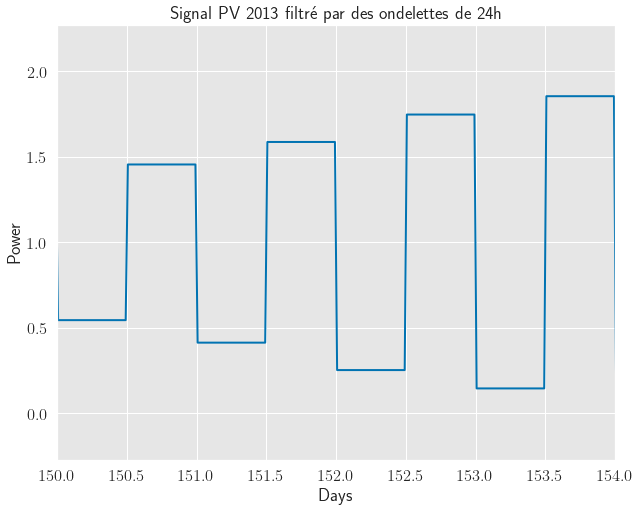

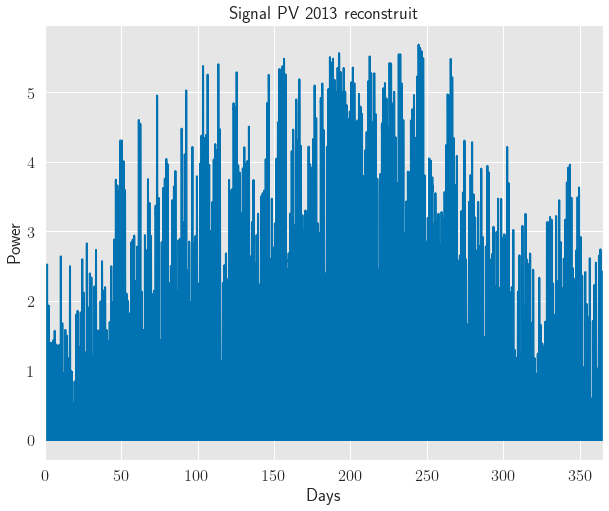

In [31]:
#
# Importing Matrix for the reconstruction
year = '2013'

path_matrix = "saved_matrix\\square_shape\\"
# path_matrix = "saved_matrix\\sine_shape\\"
matrix_name = 'A_'+ year+'.npz'

A_sparse  = sparse.load_npz(path_matrix + matrix_name)
A = sparse.csr_matrix.todense(A_sparse)
matrix = np.asarray(A)
# #
reconstruct(time_scales, [24],
                matrix,saved_sheets_square['Solaire'][year], "Signal PV 2013 filtré par des ondelettes de 24h",
                xmin=150, xmax=154,
                dpy=365, dpd=64,
                add_offset=True)

reconstruct(time_scales, time_scales,
                matrix,saved_sheets_square['Solaire'][year], "Signal PV 2013 reconstruit",
                xmin=0, xmax=365,
                dpy=365, dpd=64,
                add_offset=True)